# RHS comparison

In [31]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from kuramoto_hoi import *

sb.set_theme(style="ticks", context="notebook")

## Definitions

In [2]:
def nearest_neighbors(N, d, r):
    """
    Create a d-uniform hypergraph representing nearest neighbor relationships.

    Parameters
    ----------
    N : int
        The total number of nodes.

    d : int
        Size of hyperedges

    r : int
        The range of neighbors to consider. Neighbors within the range [-r, r]
        (excluding the node itself) will be connected.

    Returns
    -------
    xgi.Hypergraph
        A hypergraph object representing the nearest neighbor relationships.

    Raises:
    ------
    """

    r_min = int(np.ceil((d - 1) / 2))
    if r < r_min:
        raise ValueError(f"r must be >= ceil((d - 1) / 2) = {r_min} to have edges.")

    H = xgi.Hypergraph()

    nodes = np.arange(N)

    edges = []
    neighbor_rel_ids = np.concatenate((np.arange(-r, 0), np.arange(1, r + 1)))

    for i in nodes:
        neighbor_ids = i + neighbor_rel_ids
        edge_neighbors_i = combinations(neighbor_ids, d - 1)
        edges_i = [(i, *comb) for comb in edge_neighbors_i]
        edges = edges + edges_i

    edges = np.mod(edges, N)

    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    H.cleanup()  # remove duplicate edges
    return H

In [72]:
def rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
        
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i, j, k in triangles:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / g1) * pairwise + (k2 / g2) * triplet


def rhs_yuanzhao(t, theta, N, K1, K2, sigma0, sigma, return_tris=False):
    """
    RHS
    
    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """
    dtheta_dt = np.zeros(N)

    # pairwise coupling
    for ii in range(N):
        for jj in range(-K1,K1+1):
            dtheta_dt[ii] +=  sigma0*np.sin(theta[(ii+jj)%N] - theta[ii])/K1
    tris = []
    # triadic coupling
    idx = list(range(-K2,0)) + list(range(1,K2+1))
    for ii in range(N):
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    tris.append([ii, (ii+jj)%N, (ii+kk)%N])
                    #print([ii, (ii+jj)%N, (ii+kk)%N])
                    dtheta_dt[ii] +=  sigma*sin(theta[(ii+kk)%N] + theta[(ii+jj)%N] - 2*theta[ii])/(K2*(2.0*K2-1))
    
    #print(len(tris))
    if return_tris:
        return dtheta_dt, tris
    else:
        return dtheta_dt
    

def ring_hypergraph(N, r1, r2):

    H2 = nearest_neighbors(N, d=3, r=r2)
    H1 = nearest_neighbors(N, d=2, r=r1)
    H = H1 << H2
    return H

## Generate structure 

In [169]:
# structural parameters
N = 83

r1 = 2
r2 = 2
K1 = r1
K2 = r2

H = ring_hypergraph(N, r1, r2)

In [170]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)

## Tests

### The triangles are the same

In [35]:
y_yuanzhao, tris = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=True)

set([frozenset(e) for e in tris]) == set([frozenset(e) for e in triangles])

True

In [36]:
print(len(triangles))
print(len(tris))

332
996


Yuanzhao's code goes through each triangles 3 times.

### Pairwise contributions are the same

In [49]:
# dynamical parameters
omega = 0 #1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)
t = 0

In [50]:
k1 = 1  #pairwise coupling strength
k2 = 0  # triplet coupling strength
sigma0 = k1
sigma = k2

In [45]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [46]:
y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)

In [47]:
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False)

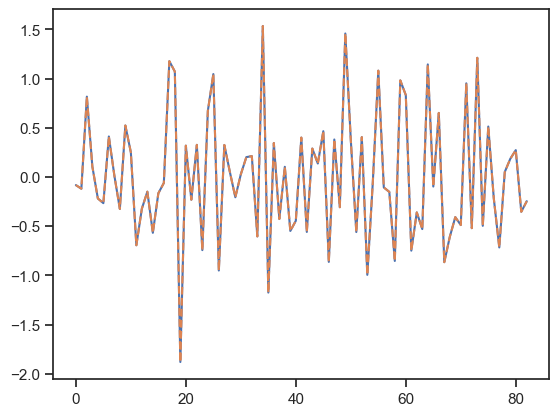

In [48]:
plt.plot(y_max)
plt.plot(y_yuanzhao, "--")

In [43]:
np.allclose(y_max, y_yuanzhao)

True

### Triplet contributions are different, but not completely uncorrelated

In [110]:
k1 = 0  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [111]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [112]:
y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False)

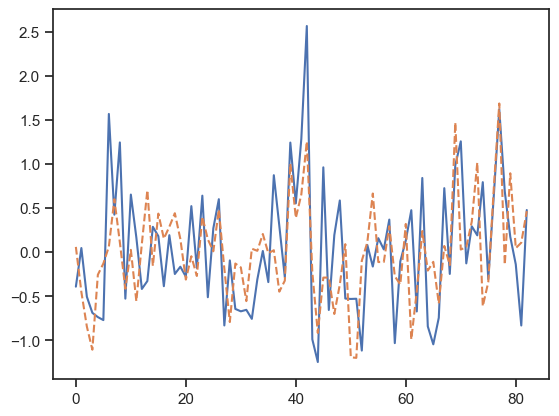

In [113]:
plt.plot(y_max)
plt.plot(y_yuanzhao, "--")

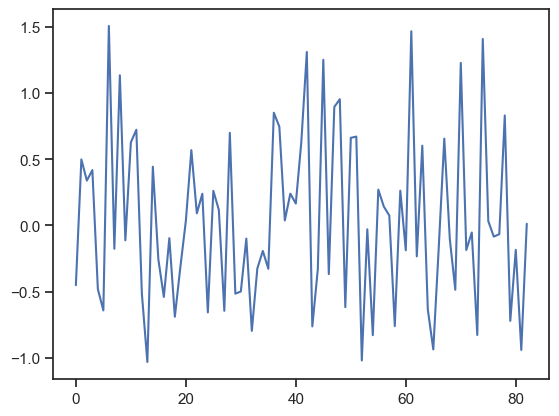

In [114]:
plt.plot(y_max - y_yuanzhao)

They look somewhat correlated, but not proportional

### They both give the right output for twisted states: zero

In [80]:
k1 = 0  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [99]:
psi = generate_state(N=N, kind="q-twisted", q=2, noise=0) # random state

In [100]:
y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False)

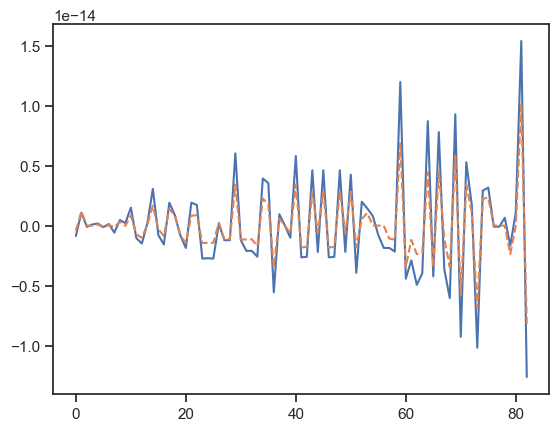

In [105]:
plt.plot(y_max)
plt.plot(y_yuanzhao, "--")

### They both give 0 for 2-cluster states

In [205]:
k1 = 0  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [206]:
psi = generate_state(N=N, kind="k-cluster", k=2, ps=[0.3, 0.7], noise=0) # random state

In [207]:
y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False)

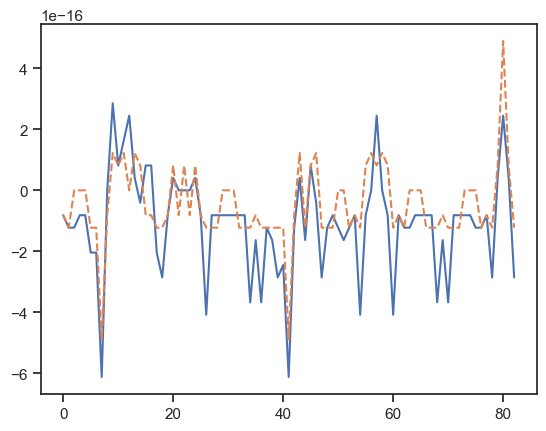

In [208]:
plt.plot(y_max)
plt.plot(y_yuanzhao, "--")

# So where and why do they differ??

Let's look at the contributions to a given node

In [189]:
def rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles, print_i=None):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
        
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i, j, k in triangles:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)
        
        if print_i in [i, j, k]:
            print(i, j, k, "\t", f"{2 * sin(oj + ok - 2 * oi) * k2 / (r2 * (2 * r2 - 1)):.3f}")

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / g1) * pairwise + (k2 / g2) * triplet


def rhs_yuanzhao(t, theta, N, K1, K2, sigma0, sigma, return_tris=False, print_i=None):
    """
    RHS
    
    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """
    dtheta_dt = np.zeros(N)

    # pairwise coupling
    for ii in range(N):
        for jj in range(-K1,K1+1):
            dtheta_dt[ii] +=  sigma0*np.sin(theta[(ii+jj)%N] - theta[ii])/K1
    tris = []
    # triadic coupling
    idx = list(range(-K2,0)) + list(range(1,K2+1))
    for ii in range(N):
        for jj in idx:
            for kk in idx:
                if jj != kk:
                    tris.append([ii, (ii+jj)%N, (ii+kk)%N])
                    #print([ii, (ii+jj)%N, (ii+kk)%N])
                    val = sigma*sin(theta[(ii+kk)%N] + theta[(ii+jj)%N] - 2*theta[ii])/(K2*(2.0*K2-1))
                    dtheta_dt[ii] += val
                    
                    indices = [ii, (ii+jj)%N, (ii+kk)%N]
                    
                    if print_i == ii:
                        print(indices, "\t", f"{val:.3f}")
    
    #print(len(tris))
    if return_tris:
        return dtheta_dt, tris
    else:
        return dtheta_dt
    

In [190]:
k1 = 0  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [191]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [192]:
ii = 0

y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles, print_i=ii)
print()
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False, print_i=ii)

0 81 1 	 -0.329
0 81 2 	 0.291
0 82 2 	 -0.138
0 1 3 	 -0.333
0 2 3 	 0.249
0 2 4 	 0.004
0 81 79 	 -0.201
80 81 0 	 -0.056
80 0 82 	 -0.332
0 81 82 	 -0.306
0 1 82 	 -0.082
0 1 2 	 -0.207

[0, 81, 82] 	 -0.153
[0, 81, 1] 	 -0.164
[0, 81, 2] 	 0.145
[0, 82, 81] 	 -0.153
[0, 82, 1] 	 -0.041
[0, 82, 2] 	 -0.069
[0, 1, 81] 	 -0.164
[0, 1, 82] 	 -0.041
[0, 1, 2] 	 -0.103
[0, 2, 81] 	 0.145
[0, 2, 82] 	 -0.069
[0, 2, 1] 	 -0.103


From this, it seems this error is in my (Max) code:  
In my code, the triangle {0 2 4} is contributing to nodes 0, 2, and 4.  
But it should only be contributing to node 2.   
In this dynamical model, triangles "are not symmetric": each node receives input from nodes at distance at most 2, even if it can be part of a triangle with a node further than distance 2.  

In [200]:
H.nodes.neighbors(0)

{1, 2, 3, 4, 79, 80, 81, 82}

In [210]:
H.edges.filterby("order", 2)

EdgeView((166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 

## Created directed ring network

In [379]:
def di_nearest_neigbors(N, d, r):
    """
    Create a d-uniform hypergraph representing nearest neighbor relationships.

    Parameters
    ----------
    N : int
        The total number of nodes.

    d : int
        Size of hyperedges

    r : int
        The range of neighbors to consider. Neighbors within the range [-r, r]
        (excluding the node itself) will be connected.

    Returns
    -------
    xgi.Hypergraph
        A hypergraph object representing the nearest neighbor relationships.
    """
    
    DH = xgi.DiHypergraph()
    nodes = np.arange(N)

    edges = []
    neighbor_rel_ids = np.concatenate((np.arange(-r, 0), np.arange(1, r + 1)))

    for i in nodes:
        neighbor_ids = i + neighbor_rel_ids
        edge_neighbors_i = combinations(neighbor_ids, d - 1)
        edges_i = [[list(np.mod(comb, N)), [i]] for comb in edge_neighbors_i]
        edges = edges + edges_i

    #edges = np.mod(edges, N)

    DH.add_nodes_from(nodes)
    DH.add_edges_from(edges)
    DH.cleanup()  # remove duplicate

    return DH

In [359]:
def rhs_dimax(t, psi, omega, k1, k2, r1, r2, dilinks, ditriangles, print_i=None):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
        
    N = len(psi)

    pairwise = np.zeros(N)
    
    for senders, receiver in dilinks:
        # sin(oj - oi)
        senders = list(senders)
        receiver = list(receiver)
        i = receiver
        j = senders
        oi = psi[i]
        oj = psi[j]
        pairwise[i] += sin(oj - oi)

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for senders, receiver in ditriangles:
        # sin(oj + ok - 2 oi)
        senders = list(senders)
        receiver = list(receiver)
        i = receiver
        j = senders[0]
        k = senders[1]
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        
        #if print_i in [i, j, k]:
        #    print(i, j, k, "\t", f"{2 * sin(oj + ok - 2 * oi) * k2 / (r2 * (2 * r2 - 1)):.3f}")

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / g1) * pairwise + (k2 / g2) * triplet


In [380]:
def ring_dihypergraph(N, r1, r2):

    H2 = di_nearest_neigbors(N, d=3, r=r2)
    H1 = di_nearest_neigbors(N, d=2, r=r1)
    
    DH = xgi.DiHypergraph()
    DH.add_nodes_from(H1.nodes)
    DH.add_edges_from(H1.edges.dimembers())
    DH.add_edges_from(H2.edges.dimembers())
    
    return DH

In [381]:
# structural parameters
N = 83

r1 = 2
r2 = 2
K1 = r1
K2 = r2

DH = ring_dihypergraph(N, r1, r2)

In [362]:
# may be used in the simulation function
dilinks = DH.edges.filterby("size", 2).dimembers()
ditriangles = DH.edges.filterby("size", 3).dimembers()
#adj1 = xgi.adjacency_matrix(DH, order=1, sparse=False)

In [375]:
k1 = 1 #pairwise coupling strength
k2 = 2  # triplet coupling strength
sigma0 = k1
sigma = k2

In [376]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [377]:
y_dimax = rhs_dimax(t, psi, omega, k1, k2, r1, r2, dilinks, ditriangles)
y_yuanzhao = rhs_yuanzhao(t, psi, N, K1, K2, sigma0, sigma, return_tris=False)

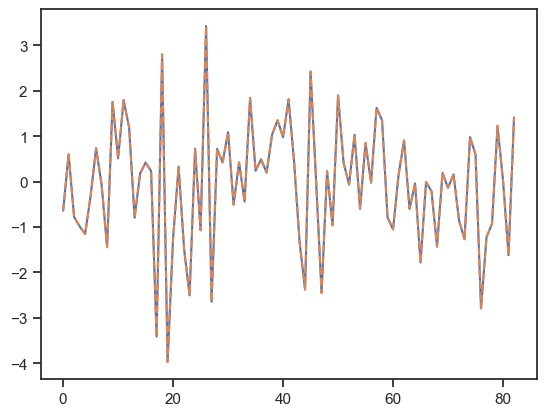

In [378]:
plt.plot(y_dimax)
plt.plot(y_yuanzhao, "--")

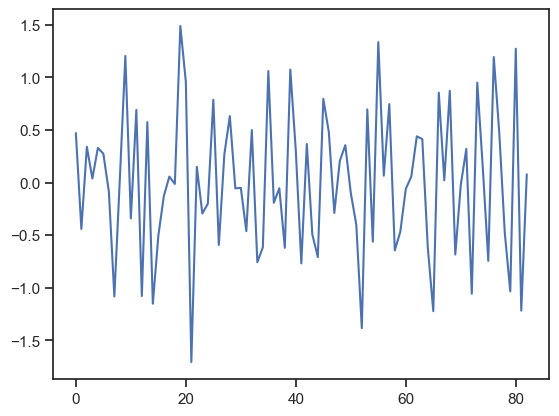

In [350]:
plt.plot(y_dimax - y_yuanzhao)